In [1]:
import numpy as np
import h5py
import numpy as np
from scipy.integrate import solve_ivp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import torch
import matplotlib.pyplot as plt

In [2]:
psi = np.load('/home/fabio/work/HM_and_AI_models/VAE_Model/x_stoch.npy')

print(psi.shape)

psi_one = psi[:, 0, :]  
print(psi_one.shape)
# # psi_one = psi_one[:, :]

psi_two = psi[:, 1, :]
# # psi_two  = psi_two[:, :]


psi = np.concatenate((psi_one, psi_two), axis=0)

print(psi.shape)

(299400, 2, 75)
(299400, 75)
(598800, 75)


In [4]:
# Pre-processing

lead = 1

trainN = 200000
valN = 50000
index = 63


print(psi.shape)
mean_psi = np.mean(psi, axis=0, keepdims=True)
std_psi = np.std(psi, axis=0, keepdims=True)
psi = (psi - mean_psi) / std_psi

psi_train_input = torch.tensor(psi[0:trainN,:])
psi_train_label =  torch.tensor(psi[lead:trainN+lead,:])

psi_val_input = torch.tensor(psi[trainN:trainN+valN,:])
psi_val_label =  torch.tensor(psi[trainN+lead:trainN+valN+lead,:])

print(psi_train_input.shape)
print(psi_train_label.shape)
print(psi_val_input.shape)
print(psi_val_label.shape)

#Total Variation Integral
def total_variation_distance(p,q):
	p = np.array(p)
	q = np.array(q)
	return 0.5 * np.sum(np.abs(p-q))

# #actual implementation
# pred_hist, _ = np.histogram(predictions, bins=50, density=True)
# actual_hist, _ = np.histogram(actual_values,bins=50,density=True)

# tvd = total_variation_distance(pred_hist,actual_hist)


(598800, 75)
torch.Size([200000, 75])
torch.Size([200000, 75])
torch.Size([50000, 75])
torch.Size([50000, 75])


(598800, 75)


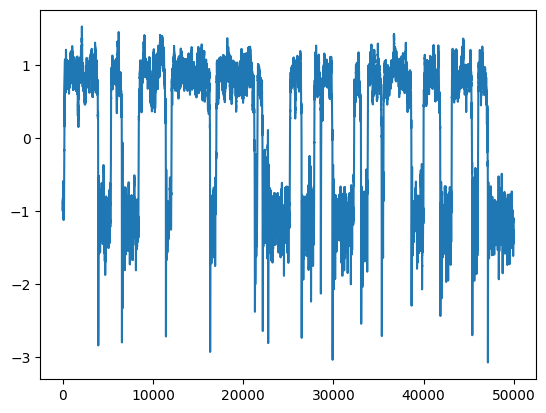

In [5]:
print(psi.shape)
# plt.plot(psi_train_input[0:200000,63])
plt.plot(psi_val_input[0:200000,63])


In [7]:
# Define the encoder (MLP)
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(75, 512)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc3 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc4 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc5 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc6 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_mu = nn.Linear(512, latent_dim)  # Hidden layer (128) -> Latent space (2)
        self.fc_logvar = nn.Linear(512, latent_dim)  # Hidden layer (128) -> Log variance (2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for hidden layer
        x = torch.relu(self.fc2(x)) + x
        x = torch.relu(self.fc3(x)) + x
        x = torch.relu(self.fc4(x)) + x
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Define the decoder (MLP)
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + condition_dim, 512)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc3 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc4 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc5 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc6 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_output = nn.Linear(512, output_dim)  # Hidden layer (128) -> Output layer (2)

    def forward(self, z, condition):
        z = torch.cat((z, condition), dim=1)  # Concatenate latent vector and condition
        z = torch.relu(self.fc1(z))  # Activation function for hidden layer
        z = torch.relu(self.fc2(z)) + z
        z = torch.relu(self.fc3(z)) + z
        z = torch.relu(self.fc4(z)) + z
        output = self.fc_output(z)
        return output

# Define the VAE model
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, output_dim, condition_dim)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z, condition):
        return self.decoder(z, condition)

    def forward(self, x, condition):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z, condition)
        return output, mu, logvar


Epoch 1, 
          Reconstrunction Loss: 4216.6357421875,
          KL Divergence Loss: 1013.2999877929688

          Validation Reconstrunction Loss: 12260.04296875,
          Validation KL Divergence Loss: 2893.9931640625
torch.Size([1, 1024]) torch.Size([1, 75])
[1.]
tensor([0.8665, 0.8844, 0.8752,  ..., 0.9764, 0.9735, 0.9743],
       dtype=torch.float64)


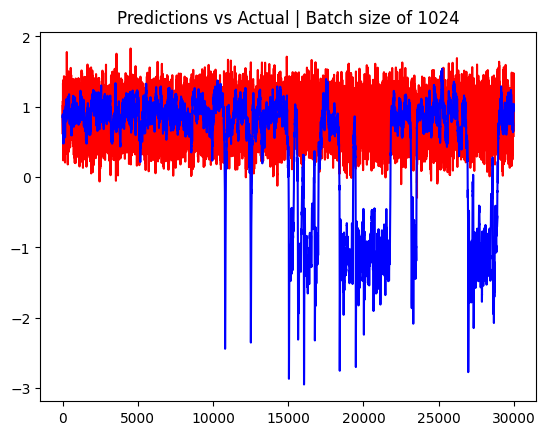

Epoch 2, 
          Reconstrunction Loss: 2046.6756591796875,
          KL Divergence Loss: 509.5347595214844

          Validation Reconstrunction Loss: 5714.080078125,
          Validation KL Divergence Loss: 1455.790771484375
torch.Size([1, 1024]) torch.Size([1, 75])
[1.]
tensor([0.8665, 0.8844, 0.8752,  ..., 0.9764, 0.9735, 0.9743],
       dtype=torch.float64)


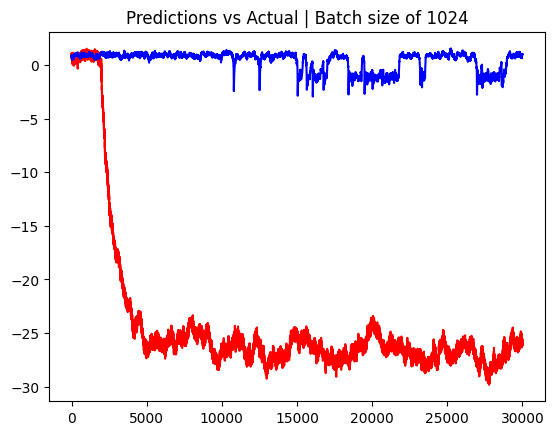

Epoch 3, 
          Reconstrunction Loss: 1446.35888671875,
          KL Divergence Loss: 335.5093688964844

          Validation Reconstrunction Loss: 3914.77490234375,
          Validation KL Divergence Loss: 957.1171264648438
torch.Size([1, 1024]) torch.Size([1, 75])
[1.]
tensor([0.8665, 0.8844, 0.8752,  ..., 0.9764, 0.9735, 0.9743],
       dtype=torch.float64)


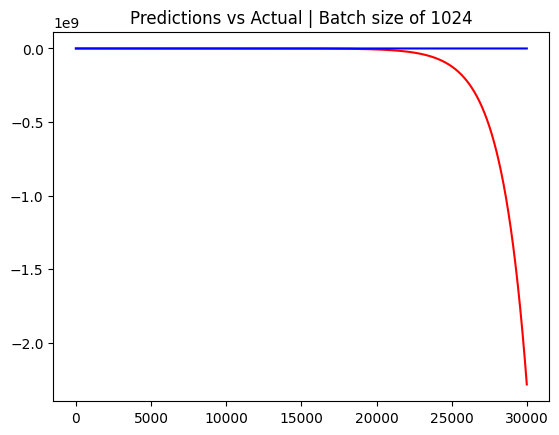

Epoch 4, 
          Reconstrunction Loss: 1172.31396484375,
          KL Divergence Loss: 246.73741149902344

          Validation Reconstrunction Loss: 3092.439453125,
          Validation KL Divergence Loss: 704.54443359375
torch.Size([1, 1024]) torch.Size([1, 75])
[1.]
tensor([0.8665, 0.8844, 0.8752,  ..., 0.9764, 0.9735, 0.9743],
       dtype=torch.float64)


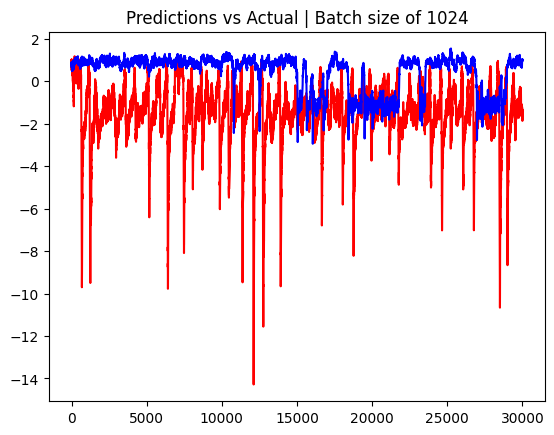

Epoch 5, 
          Reconstrunction Loss: 967.3797607421875,
          KL Divergence Loss: 192.36590576171875

          Validation Reconstrunction Loss: 2660.593505859375,
          Validation KL Divergence Loss: 549.6222534179688
torch.Size([1, 1024]) torch.Size([1, 75])
[1.]
tensor([0.8665, 0.8844, 0.8752,  ..., 0.9764, 0.9735, 0.9743],
       dtype=torch.float64)


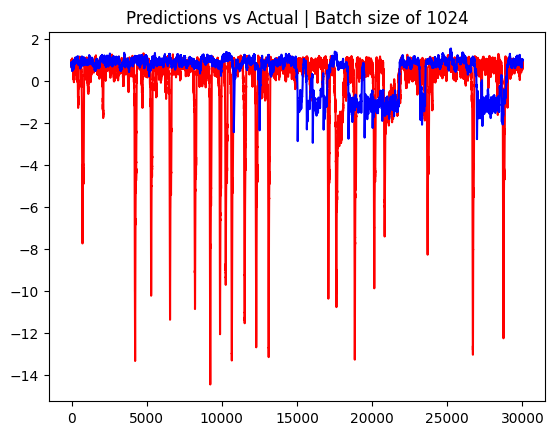

Epoch 6, 
          Reconstrunction Loss: 854.021240234375,
          KL Divergence Loss: 156.21038818359375

          Validation Reconstrunction Loss: 2298.06884765625,
          Validation KL Divergence Loss: 443.8902587890625
torch.Size([1, 1024]) torch.Size([1, 75])
[1.]
tensor([0.8665, 0.8844, 0.8752,  ..., 0.9764, 0.9735, 0.9743],
       dtype=torch.float64)


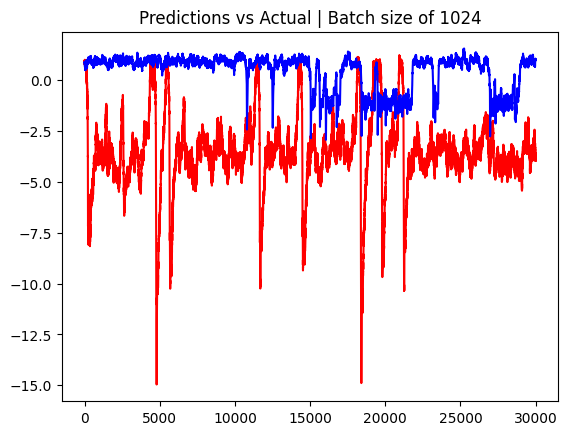

Epoch 7, 
          Reconstrunction Loss: 719.4569091796875,
          KL Divergence Loss: 129.5257110595703

          Validation Reconstrunction Loss: 1988.46484375,
          Validation KL Divergence Loss: 365.0701904296875
torch.Size([1, 1024]) torch.Size([1, 75])
[1.]
tensor([0.8665, 0.8844, 0.8752,  ..., 0.9764, 0.9735, 0.9743],
       dtype=torch.float64)


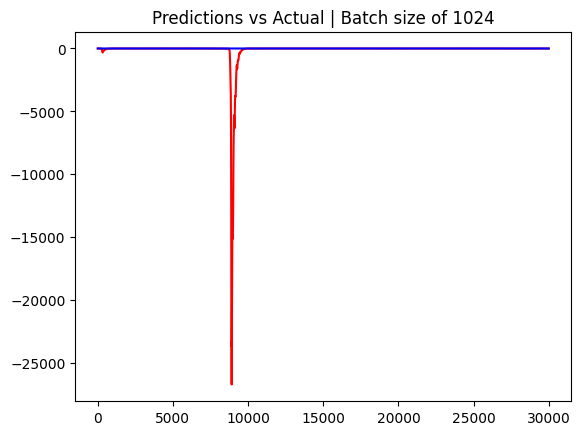

Epoch 8, 
          Reconstrunction Loss: 670.3818359375,
          KL Divergence Loss: 109.08357238769531

          Validation Reconstrunction Loss: 1765.164306640625,
          Validation KL Divergence Loss: 305.03326416015625
torch.Size([1, 1024]) torch.Size([1, 75])
[1.]
tensor([0.8665, 0.8844, 0.8752,  ..., 0.9764, 0.9735, 0.9743],
       dtype=torch.float64)


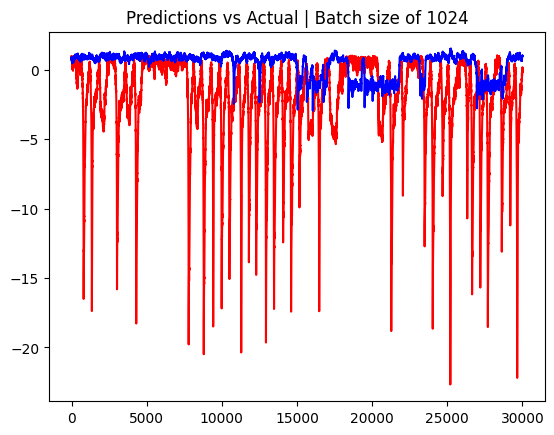

Epoch 9, 
          Reconstrunction Loss: 586.8162841796875,
          KL Divergence Loss: 95.12803649902344

          Validation Reconstrunction Loss: 1534.6290283203125,
          Validation KL Divergence Loss: 261.2015686035156
torch.Size([1, 1024]) torch.Size([1, 75])
[1.]
tensor([0.8665, 0.8844, 0.8752,  ..., 0.9764, 0.9735, 0.9743],
       dtype=torch.float64)


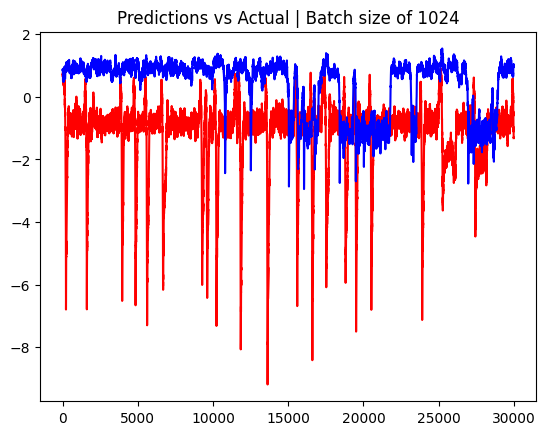

Epoch 10, 
          Reconstrunction Loss: 576.140380859375,
          KL Divergence Loss: 83.6722640991211

          Validation Reconstrunction Loss: 1423.49560546875,
          Validation KL Divergence Loss: 225.5369873046875
torch.Size([1, 1024]) torch.Size([1, 75])
[1.]
tensor([0.8665, 0.8844, 0.8752,  ..., 0.9764, 0.9735, 0.9743],
       dtype=torch.float64)


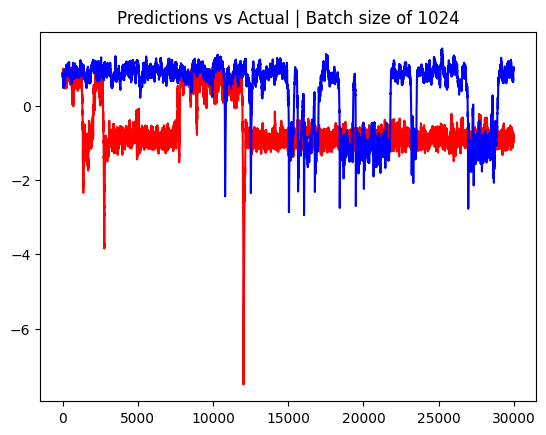

Epoch 11, 
          Reconstrunction Loss: 495.1829833984375,
          KL Divergence Loss: 84.18804168701172

          Validation Reconstrunction Loss: 1280.659423828125,
          Validation KL Divergence Loss: 212.66444396972656
torch.Size([1, 1024]) torch.Size([1, 75])
[1.]
tensor([0.8665, 0.8844, 0.8752,  ..., 0.9764, 0.9735, 0.9743],
       dtype=torch.float64)


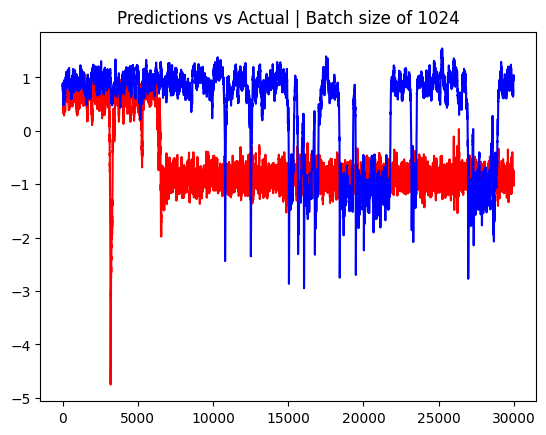

Epoch 12, 
          Reconstrunction Loss: 530.7431640625,
          KL Divergence Loss: 82.15776062011719

          Validation Reconstrunction Loss: 1299.701416015625,
          Validation KL Divergence Loss: 196.74810791015625
torch.Size([1, 1024]) torch.Size([1, 75])
[1.]
tensor([0.8665, 0.8844, 0.8752,  ..., 0.9764, 0.9735, 0.9743],
       dtype=torch.float64)


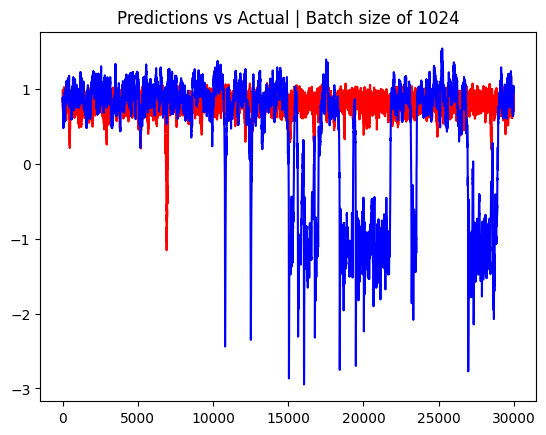

Epoch 13, 
          Reconstrunction Loss: 420.57843017578125,
          KL Divergence Loss: 65.73267364501953

          Validation Reconstrunction Loss: 1080.974609375,
          Validation KL Divergence Loss: 159.4075927734375
torch.Size([1, 1024]) torch.Size([1, 75])
[1.]
tensor([0.8665, 0.8844, 0.8752,  ..., 0.9764, 0.9735, 0.9743],
       dtype=torch.float64)


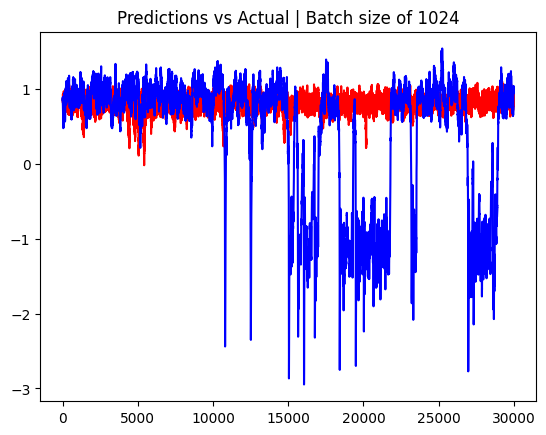

Epoch 14, 
          Reconstrunction Loss: 439.5244445800781,
          KL Divergence Loss: 61.62782287597656

          Validation Reconstrunction Loss: 1077.1524658203125,
          Validation KL Divergence Loss: 147.0987548828125
torch.Size([1, 1024]) torch.Size([1, 75])
[1.]
tensor([0.8665, 0.8844, 0.8752,  ..., 0.9764, 0.9735, 0.9743],
       dtype=torch.float64)


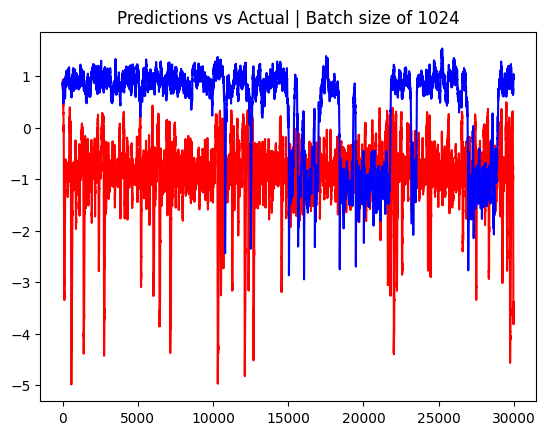

Epoch 15, 
          Reconstrunction Loss: 423.2822265625,
          KL Divergence Loss: 65.55318450927734

          Validation Reconstrunction Loss: 1043.48974609375,
          Validation KL Divergence Loss: 145.9499053955078
torch.Size([1, 1024]) torch.Size([1, 75])
[1.]
tensor([0.8665, 0.8844, 0.8752,  ..., 0.9764, 0.9735, 0.9743],
       dtype=torch.float64)


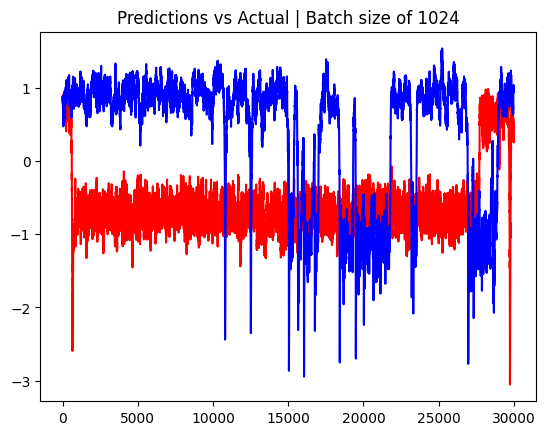

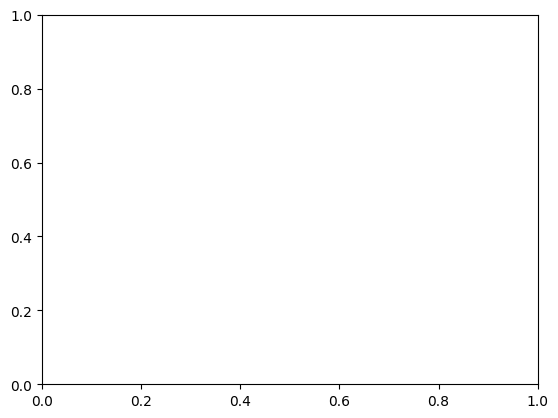

In [8]:


input_dim = 1
output_dim = 75
latent_dim = 1024
condition_dim = 75
batch_size = 1024
num_epochs = 15
prev_elem = 5

# Initialize the model, optimizer, and loss function
model = ConditionalVAE(input_dim, latent_dim, output_dim, condition_dim)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(num_epochs):
    model.train()
    for batch in range (0, trainN, batch_size):

        input_batch = psi_train_input[batch:batch + batch_size,:]
        label_batch = psi_train_label[batch:batch + batch_size,:]

        optimizer.zero_grad()

        output, mu, logvar = model(label_batch.float().cuda(), input_batch.float().cuda())

        # Reconstruction loss
        reconstruction_loss = F.mse_loss(output, label_batch.float().cuda(), reduction="sum")
        # KL divergence loss
        kl_loss = 0.5 * (mu ** 2 + torch.exp(logvar) - 1 - logvar).sum()
        
        # Total loss
        loss = reconstruction_loss + 10 * kl_loss

        loss.backward()
        optimizer.step()


# Train the model
# for epoch in range(num_epochs):
#     model.train()
#     for batch in range(0, trainN, batch_size):
#         batch_end = min(batch + batch_size, trainN)
#         batch_inputs = []
#         for i in range(batch, batch_end):
#             if i < prev_elem:
#                 # Pad with zeros if not enough previous elements
#                 num_missing = prev_elem - i
#                 pad = torch.zeros((num_missing, psi_train_input.size(1)), device=psi_train_input.device)
#                 seq = torch.cat((pad, psi_train_input[0:i+1, :]), dim=0)
#             else:
#                 seq = psi_train_input[i-prev_elem:i+1, :]
#             # Flatten the sequence into a single vector
#             batch_inputs.append(seq.flatten())
#         input_batch = torch.stack(batch_inputs)
#         label_batch = psi_train_label[batch:batch_end, :]

#         optimizer.zero_grad()

#         output, mu, logvar = model(label_batch.float().cuda(), input_batch.float().cuda())

#         # Reconstruction loss
#         reconstruction_loss = F.mse_loss(output, label_batch.float().cuda(), reduction="sum")
#         # KL divergence loss
#         kl_loss = 0.5 * (mu ** 2 + torch.exp(logvar) - 1 - logvar).sum()
        
#         # Total loss
#         loss = reconstruction_loss + 10 * kl_loss

#         loss.backward()
#         optimizer.step()


    print(f'''Epoch {epoch+1}, 
          Reconstrunction Loss: {reconstruction_loss},
          KL Divergence Loss: {kl_loss}''')

    # Validation Loss
    for batch in range (0, valN, batch_size):

        input_batch = psi_val_input[batch:batch + batch_size,:]
        label_batch = psi_val_label[batch:batch + batch_size,:]
        
        output, mu, logvar = model(label_batch.float().cuda(), input_batch.float().cuda())
        reconstruction_loss = F.mse_loss(output, label_batch.float().cuda(), reduction="sum")
        kl_loss = 0.5 * (mu ** 2 + torch.exp(logvar) - 1 - logvar).sum()
        val_loss = reconstruction_loss + 10 * kl_loss # Experiment HIGHER coefficients
        # Print both reconstruction_loss and kl_loss

    print(f'''
          Validation Reconstrunction Loss: {reconstruction_loss},
          Validation KL Divergence Loss: {kl_loss}''')

    # Inference

    initial_cond = torch.reshape(torch.tensor(psi[0,:]), [1, 75])
    time_step = 30000
    z = torch.zeros([1,latent_dim])
    num_ens = 1
    pred = np.zeros ([time_step, 75, num_ens])


    for k in range (0, time_step):

        for ens in range (0, num_ens):
            if (k ==0):

                z = torch.randn_like(z)
                print(z.shape, initial_cond.shape)
                y = (model.decode(z.float().cuda(),initial_cond.float().cuda())).detach().cpu().numpy()
                pred[k,:,ens] = y
                y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
                initial_cond = torch.tensor((y_denorm - mean_psi[:, :]) / std_psi[:, :])

            else:
                select_ens = np.random.randint(0,num_ens,1)
                z = torch.randn_like(z)
                y = (model.decode(z.float().cuda(),torch.reshape(torch.tensor(pred[k-1,:,select_ens]),[1,75]).float().cuda())).detach().cpu().numpy()
                pred[k,:, ens] = y
                y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
                initial_cond = torch.tensor((y_denorm - mean_psi[:, :]) / std_psi[:, :])

        
    # Denormalize final preds
    print(std_psi[:, 63])
    pred_mean = pred * std_psi[:, 63] + mean_psi[:, 63]

    # Denormalize test labels
    actual_values = psi_train_label[:time_step, 63] * std_psi[:, 63] + mean_psi[:, 63]
    print(actual_values)

    plt.plot(pred_mean[0:30000,63],'r')
    plt.plot(actual_values[0:30000],'b')
    plt.title(f"Predictions vs Actual | Batch size of {batch_size}")
    plt.show()
    plt.cla()